In [2]:
import numpy as np
import cv2
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm  
import os

In [5]:
import numpy as np

def generate_image(size, img_size, base_sigma=0.05, sigma_scale= .1):
    """
    Generate an image with a Gaussian dot of a specific size in the center.
    
    Args:
        size: The normalized size of the dot (0 to 1, representing the radius as a fraction of the image dimensions).
        img_size: Tuple indicating the desired canvas size (height, width).
        base_sigma: Minimum standard deviation for the Gaussian to control sharpness.
        sigma_scale: Scaling factor for adjusting the standard deviation relative to the dot size.
    
    Returns:
        canvas: A NumPy array representing the generated image.
    """
    height, width = img_size
    canvas = np.zeros((height, width), dtype=np.float32)  # Initialize the canvas
    
    # Calculate the center of the canvas
    center_y, center_x = height // 2, width // 2
    
    # Calculate the radius and sigma for the Gaussian
    dot_radius = size * min(height, width) / 2  # Convert normalized size to pixel radius
    sigma = max(dot_radius * sigma_scale, base_sigma)  # Ensure sigma does not drop below base_sigma
 
    # Create the Gaussian using a distance mask
    y, x = np.ogrid[:height, :width]
    distance_from_center_squared = (x - center_x)**2 + (y - center_y)**2
    
    # Compute Gaussian intensity profile
    canvas = np.exp(-distance_from_center_squared / (2 * sigma**2))
    
    # Normalize the canvas to keep values between 0 and 1
    canvas /= canvas.max()
    
    return canvas




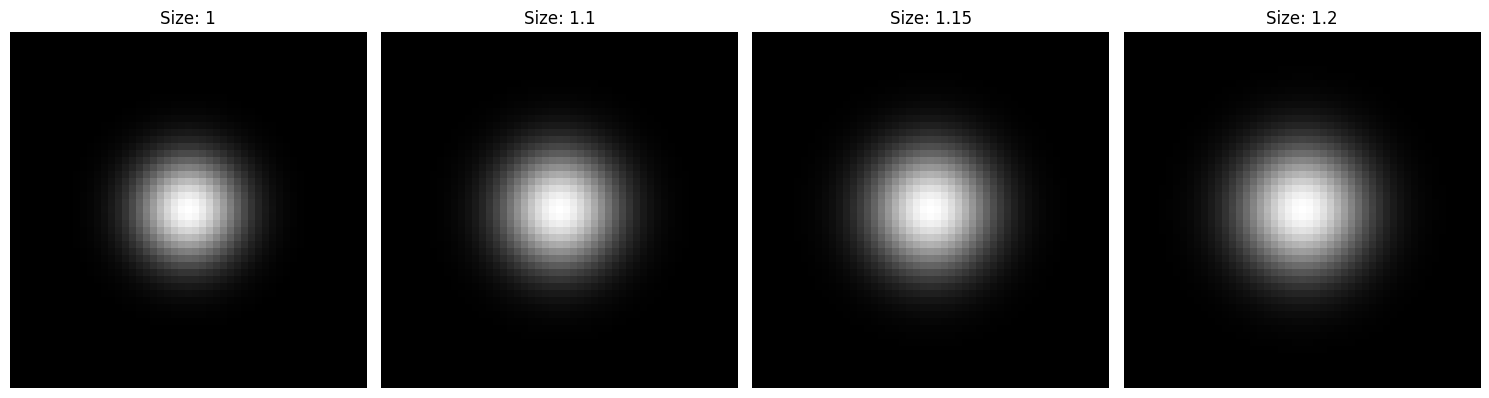

In [6]:
import matplotlib.pyplot as plt

# Parameters
img_size = (51, 51)  # Canvas size
sizes = [1, 1.1, 1.15, 1.2]  # Different normalized dot sizes
sigma_scale = 0.2
base_sigma = .1

# Generate and display Gaussian dots
fig, axes = plt.subplots(1, len(sizes), figsize=(15, 5))
for ax, size in zip(axes, sizes):
    img = generate_image(size, img_size, base_sigma=base_sigma, sigma_scale=sigma_scale)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Size: {size}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [8]:
def save_trajectory(num_timesteps= 101, delta_t = .02, img_size=(51, 51), output_file="trajectories.npz", num_ics=200):
    """
    Save trajectories, their derivatives, and size values for both true and counterfactual scenarios.

    Args:
        num_timesteps: Number of time steps in the trajectory.
        img_size: Desired image size (width, height).
        output_file: Path to save the .npz file.
        num_ics: Number of initial conditions to generate per label.
    """
    K = 1
    alpha = 1.0
    delta_t = delta_t  # Time step interval
    epsilon = 1e-5

    # Preallocate lists for structured data
    image_ids = []
    true_images = []
    true_derivatives = []
    true_sizes = []  # To store sizes for the true trajectory

    for ic in range(num_ics):
        init_size = np.random.uniform(0.05, 1.0)  # Initial size of the dot

        # Initialize for true trajectory
        size_t = init_size
        true_traj = []
        true_img_der = []
        true_size_traj = []  # Collect sizes for the true trajectory

        for t in range(num_timesteps):
            # Generate the dot image
            img = generate_image(size=size_t, img_size=img_size)
            d_size_dt = (alpha * (1 - size_t / K)) * size_t
            #d_size_dt = 1 - size_t

            # #derivative calc
            # img_plus = generate_image(size=size_t + epsilon, img_size=img_size)
            # img_minus = generate_image(size=size_t - epsilon, img_size=img_size)
            # # Approximate the gradient using finite differences
            # gradient = (img_plus - img_minus) / (2 * epsilon)
       
            # true_img_der.append(gradient)
            # true_traj.append(img)
            # true_size_traj.append(size_t)

            if t > 0:
                # Compute derivative on normalized images
                img_derivative = (img - prev_img) / delta_t
                true_img_der.append(img_derivative)
                true_traj.append(img)
                true_size_traj.append(size_t)

            prev_img = img
            size_t += d_size_dt * delta_t

        # Append structured data
        image_ids.append(ic)
        true_images.append(np.array(true_traj))
        true_derivatives.append(np.array(true_img_der))
        true_sizes.append(np.array(true_size_traj))

    # Save structured data
    np.savez_compressed(output_file,
                        image_ids=np.array(image_ids),
                        x=np.array(true_images),
                        dx=np.array(true_derivatives),
                        o=np.array(true_sizes))


In [9]:
# Generate trajectories
output_dir = '/usr/local/data/anitakriz/ode/lte/dot/data/untreated/'
os.makedirs(output_dir, exist_ok=True)

save_trajectory(
    img_size = (51, 51),
    num_timesteps = 11,
    delta_t = .02,
    output_file=os.path.join(output_dir, 'dot_train_traj.npz'),
    num_ics = 5000
      # Number of initial conditions
)
save_trajectory(
    img_size = (51,51),
    num_timesteps = 11,
    delta_t = .02,
    output_file=os.path.join(output_dir, 'dot_val_traj.npz'),
    num_ics= 500  # Number of initial conditions
)
save_trajectory(
    img_size = (51,51),
    num_timesteps = 11,
    delta_t = .02,
    output_file=os.path.join(output_dir, 'dot_test_traj.npz'),
    num_ics= 500  # Number of initial conditions
)

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def count_identical_images(images):
    """
    Count how many images are visually identical based on their pixel values.
    
    Args:
        images (numpy.ndarray): Array of images with shape (n_samples, width, height).
    
    Returns:
        int: Number of duplicate images.
        dict: A mapping of unique pixel content to the number of occurrences.
    """
    # Dictionary to store unique image representations
    image_groups = {}
    
    for i, img in enumerate(images):
        # Convert image to a tuple for hashability and easy comparison
        img_tuple = tuple(img.flatten())
        
        # Use the tuple as a key for grouping identical images
        if img_tuple in image_groups:
            image_groups[img_tuple].append(i)
        else:
            image_groups[img_tuple] = [i]
    
    # Count duplicates (images that have more than one occurrence)
    duplicate_count = sum(len(indices) - 1 for indices in image_groups.values() if len(indices) > 1)
    
    return duplicate_count, image_groups

# Example usage
data = np.load('/usr/local/data/anitakriz/ode/lte/dot/data/untreated/dot_train_traj.npz', allow_pickle=True)
images = data['x'].reshape(-1, 51, 51)  # Reshape to (n_samples, width, height)
sizes = data['o'].reshape(-1)  # Assuming data['o'] contains sizes corresponding to images

duplicates, image_groups = count_identical_images(images)
print("Number of duplicates:", duplicates)
# plot_identical_image_groups(images, image_groups, sizes)

Number of duplicates: 0


In [9]:
data = np.load('/usr/local/data/anitakriz/ode/lte/dot/data/untreated/dot_train_traj.npz', allow_pickle=True)

# Extract dx (derivatives)
dx = data['dx']  # Shape: (total_trajectories, num_timesteps, img_size, img_size)
print(dx.shape)
# Initialize the counter for zero derivatives
zero_count = 0

# Loop over all trajectories and timesteps
for trajectory_idx in range(dx.shape[0]):  # Iterate over trajectories
    for timestep_idx in range(dx.shape[1]):  # Iterate over timesteps
        # Check if all elements in the dx matrix are zero for this trajectory and timestep
        if np.all(dx[trajectory_idx, timestep_idx] == 0):
            zero_count += 1

# Print the total count of zero derivatives
print(f"Total number of zero derivatives (dx=0) across all trajectories and timesteps: {zero_count} out of {data['dx'].shape[0] * data['dx'].shape[1]}")


(5000, 10, 51, 51)
Total number of zero derivatives (dx=0) across all trajectories and timesteps: 0 out of 50000


In [10]:
data = np.load('/usr/local/data/anitakriz/ode/lte/dot/data/untreated/dot_train_traj.npz', allow_pickle=True)

# Extract x (images), dx (derivatives), sizes (o), and other metadata
x = data['x']  # Shape: (total_trajectories, num_timesteps, img_size, img_size)
dx = data['dx']  # Shape: (total_trajectories, num_timesteps, img_size, img_size)
sizes = data['o']  # Shape: (total_trajectories, num_timesteps)
image_ids = data['image_ids']  # Corresponding image IDs

In [11]:
from pysindy import SINDy
import pysindy as ps
t = np.arange(0,.2,0.02)
sizes_reshaped = [sizes[i, :] for i in range(sizes.shape[0])]

model = SINDy(feature_library = ps.PolynomialLibrary(degree = 3))
model.fit(x = sizes_reshaped, t = t, multiple_trajectories = True)
model.print()

(x0)' = 0.998 x0 + -0.997 x0^2


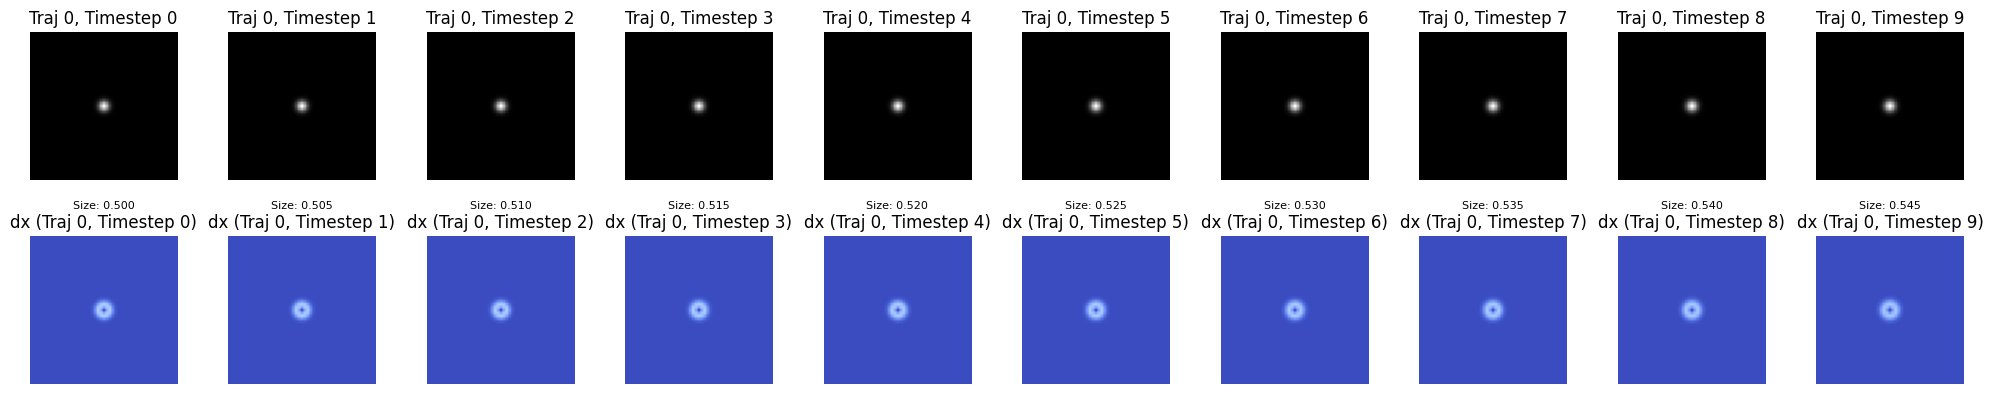

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Load data
data = np.load('/usr/local/data/anitakriz/ode/lte/dot/data/untreated/dot_train_traj.npz', allow_pickle=True)

# Extract x (images), dx (derivatives), sizes (o), and other metadata
x = data['x']  # Shape: (total_trajectories, num_timesteps, img_size, img_size)
dx = data['dx']  # Shape: (total_trajectories, num_timesteps, img_size, img_size)
sizes = data['o']  # Shape: (total_trajectories, num_timesteps)

# Select trajectories and timesteps to plot
trajectory_indices = [0]  # Indices of trajectories to display
num_timesteps = 10
timesteps_to_show = np.linspace(0, num_timesteps - 1, num_timesteps, dtype=int)  # Select timesteps

# Fixed normalization range for dx plots
norm = Normalize(vmin=0, vmax = 1)

# Create subplots
num_trajectories = len(trajectory_indices)
fig, axes = plt.subplots(num_trajectories * 2, len(timesteps_to_show), 
                         figsize=(len(timesteps_to_show) * 2, num_trajectories * 4))

# Loop over trajectories
for row, trajectory_idx in enumerate(trajectory_indices):
    for col, t_idx in enumerate(timesteps_to_show):
        # Plot x (image)
        axes[row * 2, col].imshow(x[trajectory_idx, t_idx], cmap='gray', origin='lower')
        axes[row * 2, col].set_title(f"Traj {trajectory_idx}, Timestep {t_idx}")
        axes[row * 2, col].axis('off')
        # Add size below the image
        axes[row * 2, col].text(0.5, -0.2, f"Size: {sizes[trajectory_idx, t_idx]:.3f}",
                                fontsize=8, ha='center', transform=axes[row * 2, col].transAxes)

        # Plot dx (derivative)
        axes[row * 2 + 1, col].imshow(dx[trajectory_idx, t_idx], cmap='coolwarm', norm=norm, origin='lower')
        axes[row * 2 + 1, col].set_title(f"dx (Traj {trajectory_idx}, Timestep {t_idx})")
        axes[row * 2 + 1, col].axis('off')

# Add labels for rows
for row in range(num_trajectories):
    axes[row * 2, 0].set_ylabel(f'Traj {trajectory_indices[row]}: x', fontsize=12)
    axes[row * 2 + 1, 0].set_ylabel(f'Traj {trajectory_indices[row]}: dx', fontsize=12)

plt.tight_layout()
plt.show()
